# Credit Card Default Prediction

This project was created within the scope of the course *ID2221/FID3019 HT23 Data-Intensive Computing* which I took during my Machine Learning programme (M.Sc.) at KTH, Stockholm.

The goal of this project was to evaluate methods that could be used to perform credit card default predictions and be applied to large amounts of data. Being able to predict which customers will default is of special importance for financial institutions to predict which customers will default on their credit cards in order to take preventative measures and minimize losses.

For this project, the Taiwan bank dataset regarding credit card clients and their default status was used which is available on the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients).
The dataset consists of 30,000 instances whereof 6,636 are default cases. There are 23 features including gender, marital status, history of the past 6 months payment records, and past 6 months re-payment status. The defaulting variable which is the target variable is binary: 0 indicating a non-default record and 1 indicating a default case.





##PySpark installation for local environment

In [ ]:
#!conda install pyspark

##PySpark installation for Colab environment

In [ ]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
# Unzip the file
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.5.0-bin-hadoop3'

In [ ]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.5.0-bin-hadoop3'

## Imports and initialize Spark

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col, round, split, col, regexp_extract, when, lit
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorSlicer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
sc = SparkContext('local')
#sc = SparkContext.getOrCreate('local') # use this if running Notebook again and Colab complains that Context already exists
spark = SparkSession(sc)

## Read in data to local environment

In [ ]:
# if you want to use this, you have to move the csv file to the runtime environment
#data = spark.read.csv('default_of_credit_card_clients.csv', header=True)

## Read in data to Colab environment from Google Drive Folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# first make sure Drive is mounted and that dataset exists at listed filepath
#/content/drive/MyDrive/Colab Notebooks/default_of_credit_card_clients.csv

data = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/default_of_credit_card_clients.csv',header = 'True',inferSchema='True')

In [ ]:
# Cache the data so that we only read it from disk once.
data.cache()
data.is_cached            # Checks if df is cached


True

## Check data

In [ ]:
data.dtypes

[('_c0', 'string'),
 ('X1', 'string'),
 ('X2', 'string'),
 ('X3', 'string'),
 ('X4', 'string'),
 ('X5', 'string'),
 ('X6', 'string'),
 ('X7', 'string'),
 ('X8', 'string'),
 ('X9', 'string'),
 ('X10', 'string'),
 ('X11', 'string'),
 ('X12', 'string'),
 ('X13', 'string'),
 ('X14', 'string'),
 ('X15', 'string'),
 ('X16', 'string'),
 ('X17', 'string'),
 ('X18', 'string'),
 ('X19', 'string'),
 ('X20', 'string'),
 ('X21', 'string'),
 ('X22', 'string'),
 ('X23', 'string'),
 ('Y', 'string')]

In [ ]:
data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- X1: string (nullable = true)
 |-- X2: string (nullable = true)
 |-- X3: string (nullable = true)
 |-- X4: string (nullable = true)
 |-- X5: string (nullable = true)
 |-- X6: string (nullable = true)
 |-- X7: string (nullable = true)
 |-- X8: string (nullable = true)
 |-- X9: string (nullable = true)
 |-- X10: string (nullable = true)
 |-- X11: string (nullable = true)
 |-- X12: string (nullable = true)
 |-- X13: string (nullable = true)
 |-- X14: string (nullable = true)
 |-- X15: string (nullable = true)
 |-- X16: string (nullable = true)
 |-- X17: string (nullable = true)
 |-- X18: string (nullable = true)
 |-- X19: string (nullable = true)
 |-- X20: string (nullable = true)
 |-- X21: string (nullable = true)
 |-- X22: string (nullable = true)
 |-- X23: string (nullable = true)
 |-- Y: string (nullable = true)



In [ ]:
data.first()

Row(_c0='ID', X1='LIMIT_BAL', X2='SEX', X3='EDUCATION', X4='MARRIAGE', X5='AGE', X6='PAY_0', X7='PAY_2', X8='PAY_3', X9='PAY_4', X10='PAY_5', X11='PAY_6', X12='BILL_AMT1', X13='BILL_AMT2', X14='BILL_AMT3', X15='BILL_AMT4', X16='BILL_AMT5', X17='BILL_AMT6', X18='PAY_AMT1', X19='PAY_AMT2', X20='PAY_AMT3', X21='PAY_AMT4', X22='PAY_AMT5', X23='PAY_AMT6', Y='default payment next month')

In [ ]:
from functools import reduce

In [ ]:
data.show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------+
|_c0|       X1| X2|       X3|      X4| X5|   X6|   X7|   X8|   X9|  X10|  X11|      X12|      X13|      X14|      X15|      X16|      X17|     X18|     X19|     X20|     X21|     X22|     X23|                   Y|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment n...|
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|      

## Data cleaning


In [ ]:
#select the row with the header name
header = data.filter((data['X1'] == 'LIMIT_BAL') )

#selecting the rest of the rows except the first one
restDF = data.subtract(header)

#converting the header row into Row
from pyspark.sql.types import IntegerType, FloatType
headerColumn = header.first()

#looping columns for renaming
for column in restDF.columns:
    restDF = restDF.withColumnRenamed(column, headerColumn[column])

restDF = restDF.withColumn("ID", restDF["ID"].cast(IntegerType()))
restDF.sort('ID').show(truncate=False)

df = restDF

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|ID |LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|1  |20000    |2  |2        |1       |24 |2    |2    |-1   |-1   |-2   |-2   |3913     |3102     |689      |0        |0        |0        |0       |689     |0       |0       |0       |0       |1                         |
|2  |120000   |2  |2        |2       |26 |-1   |2    |0    |0    |0    |2    |2682     |1725     |2682     |3272     |34

In [ ]:
df_default = df.filter(df['default payment next month']==1)

In [ ]:
# Rename PAY_0 to PAY_1:
df = df.withColumnRenamed("PAY_0","PAY_1")

df_default = df_default.withColumnRenamed("PAY_0","PAY_1")

In [ ]:
df = df.withColumnRenamed("default payment next month", "default")

In [ ]:
df.sort('ID').show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|      1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|       0|    2000|    

In [ ]:
# Replace marriage values: 0, to 3:
# MARITAL STATUS: (1 = married; 2 = single; 3 = others).
df = df.withColumn(
    'MARRIAGE',
    when((df['MARRIAGE'] == 0) , 3)
    .otherwise(df['MARRIAGE'])
)

df_default = df_default.withColumn(
    'MARRIAGE',
    when((df_default['MARRIAGE'] == 0) , 3)
    .otherwise(df_default['MARRIAGE'])
)

In [ ]:
# Replace education values: 0, 5, 6 to 4:
# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
df = df.withColumn(
    'EDUCATION',
    when((df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6), 4)
    .otherwise(df['EDUCATION'])
)

df_default = df_default.withColumn(
    'EDUCATION',
    when((df_default['EDUCATION'] == 0) | (df_default['EDUCATION'] == 5) | (df_default['EDUCATION'] == 6), 4)
    .otherwise(df_default['EDUCATION'])
)

In [ ]:
# Check for duplicate IDs

df.groupby(['ID']).count().where('count > 1').sort('count', ascending=False).show()

+---+-----+
| ID|count|
+---+-----+
+---+-----+



In [ ]:
df.agg(F.countDistinct(df.ID)).collect()

[Row(count(DISTINCT ID)=30000)]

In [ ]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: string (nullable = true)
 |-- SEX: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- MARRIAGE: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- PAY_1: string (nullable = true)
 |-- PAY_2: string (nullable = true)
 |-- PAY_3: string (nullable = true)
 |-- PAY_4: string (nullable = true)
 |-- PAY_5: string (nullable = true)
 |-- PAY_6: string (nullable = true)
 |-- BILL_AMT1: string (nullable = true)
 |-- BILL_AMT2: string (nullable = true)
 |-- BILL_AMT3: string (nullable = true)
 |-- BILL_AMT4: string (nullable = true)
 |-- BILL_AMT5: string (nullable = true)
 |-- BILL_AMT6: string (nullable = true)
 |-- PAY_AMT1: string (nullable = true)
 |-- PAY_AMT2: string (nullable = true)
 |-- PAY_AMT3: string (nullable = true)
 |-- PAY_AMT4: string (nullable = true)
 |-- PAY_AMT5: string (nullable = true)
 |-- PAY_AMT6: string (nullable = true)
 |-- default: string (nullable = true)



In [ ]:
df.filter(df.SEX.isNull()).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+



In [ ]:
[c for c in df.columns]

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default']

In [ ]:
null_counts = df.select([F.sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns])
null_counts.show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  0|        0|  0|        0|       0|  0|    0|    0|    0|    0|    0|    0|        0|        0|        0|        0|        0|        0|       0|       0|       0|       0|       0|       0|      0|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+----

## Exploratory data analysis (EDA) of cleaned data

<Axes: >

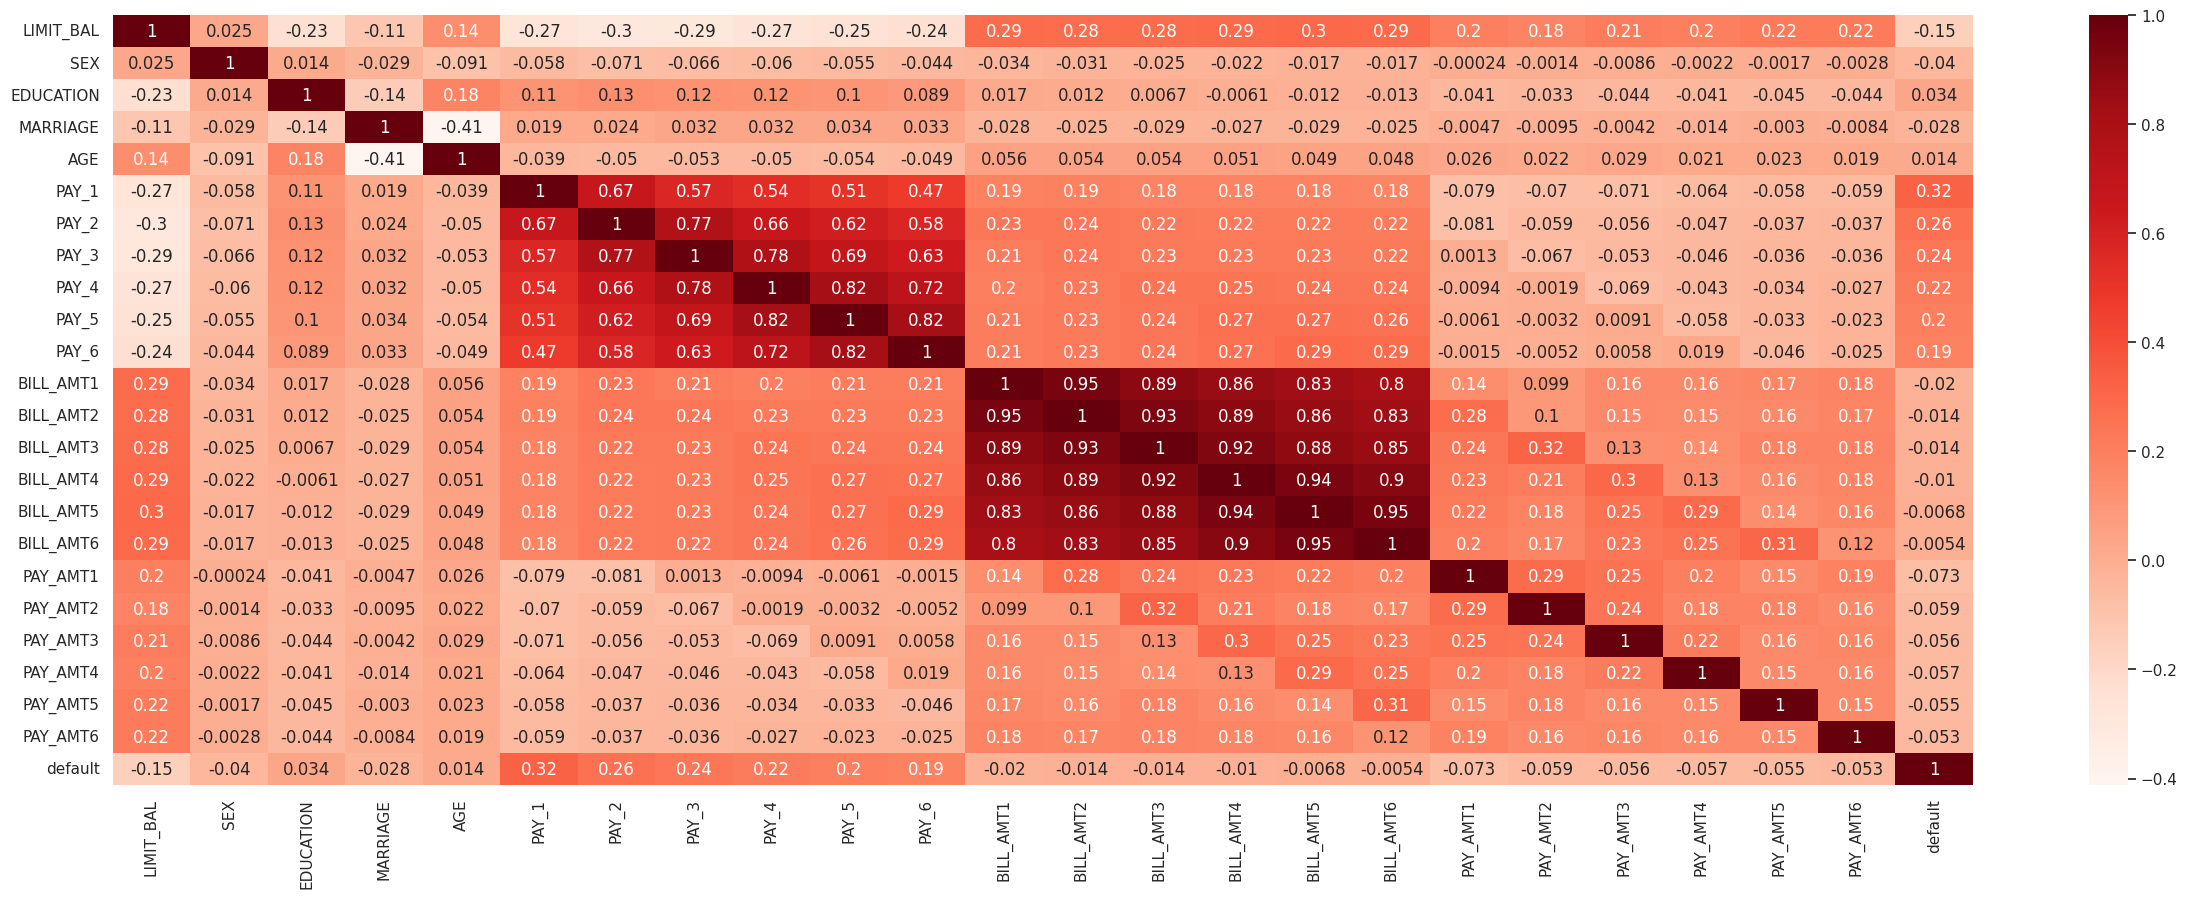

In [ ]:
# Heat map for total data in order to visualize correlation between features
# see: https://www.kaggle.com/code/yapsoonchung/eda-on-default-of-credit-card-clients-dataset#Data-Cleaning

pdf_heat=df.toPandas()
pdf_heat=pdf_heat.iloc[:,1:]
pdf_heat=pdf_heat.apply(pd.to_numeric)
sns.set(rc={'figure.figsize':(30,10)})
sns.heatmap(pdf_heat.corr(), cmap='Reds', annot=True)


In [ ]:
# plot function

def plot_total_default_percentage(df_plot, x, title, x_label, y_label, x_ticklabels):
    pdf = df_plot.toPandas()
    ax=pdf.plot.bar(x=x, rot=0, figsize=(9,6))
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(x_ticklabels)

In [ ]:
#  Number of rows (data records)
df.count()                # 30000


30000

In [ ]:
#  Number of columns (ID, 23 features used for prediction, 1 varible to be predicted)
len(df.columns)            #25

25

In [ ]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: string (nullable = true)
 |-- SEX: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- MARRIAGE: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- PAY_1: string (nullable = true)
 |-- PAY_2: string (nullable = true)
 |-- PAY_3: string (nullable = true)
 |-- PAY_4: string (nullable = true)
 |-- PAY_5: string (nullable = true)
 |-- PAY_6: string (nullable = true)
 |-- BILL_AMT1: string (nullable = true)
 |-- BILL_AMT2: string (nullable = true)
 |-- BILL_AMT3: string (nullable = true)
 |-- BILL_AMT4: string (nullable = true)
 |-- BILL_AMT5: string (nullable = true)
 |-- BILL_AMT6: string (nullable = true)
 |-- PAY_AMT1: string (nullable = true)
 |-- PAY_AMT2: string (nullable = true)
 |-- PAY_AMT3: string (nullable = true)
 |-- PAY_AMT4: string (nullable = true)
 |-- PAY_AMT5: string (nullable = true)
 |-- PAY_AMT6: string (nullable = true)
 |-- default: string (nullable = true)



In [ ]:
df.filter(df['default']==1).count()

6636

### Exploring proportions and distributions of features

In [ ]:
# See the default proportion (0=no default, 1=yes) of the population:
df.groupBy('default').agg((F.count('default')*100 / df.count()).alias('default_proportion')).show()

+-------+------------------+
|default|default_proportion|
+-------+------------------+
|      0|             77.88|
|      1|             22.12|
+-------+------------------+



[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

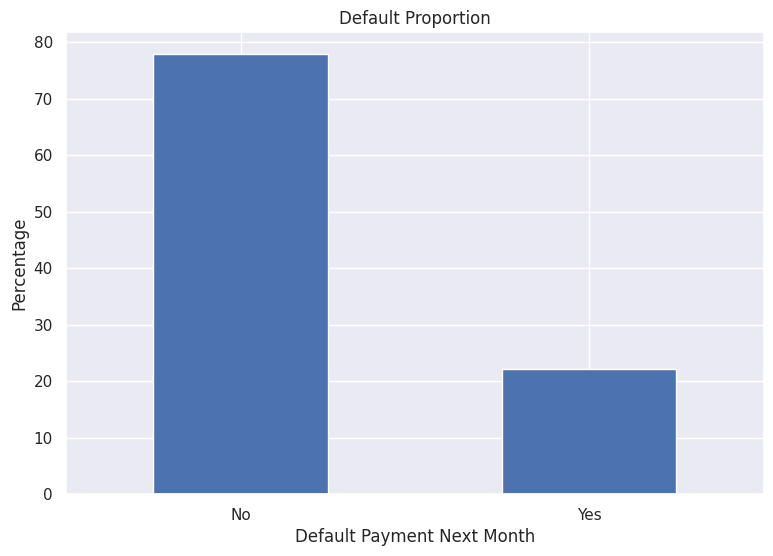

In [ ]:
# plot the default proportion

pdf_default = df.groupBy('default').agg((F.count('default')*100 / df.count()).alias('default_proportion')).toPandas()
ax= pdf_default.plot.bar(x = 'default', y='default_proportion', rot=0, legend=None, figsize=(9,6))
ax.set_title('Default Proportion')
ax.set_xlabel('Default Payment Next Month')
ax.set_ylabel('Percentage')
ax.set_xticklabels(('No', 'Yes'))

In [ ]:
# See the sex proportion (1=male, 2=female) of the total and default population
tmp_sex = df.groupBy('SEX').agg((round(F.count('SEX')*100 / df.count(),2)).alias('Percentage_total'))

tmp_sex.join(df_default.groupBy('SEX').agg(round(F.count('SEX')*100 / df_default.count(),2).alias('Percentage_default')), 'SEX').show()


+---+----------------+------------------+
|SEX|Percentage_total|Percentage_default|
+---+----------------+------------------+
|  1|           39.63|             43.29|
|  2|           60.37|             56.71|
+---+----------------+------------------+



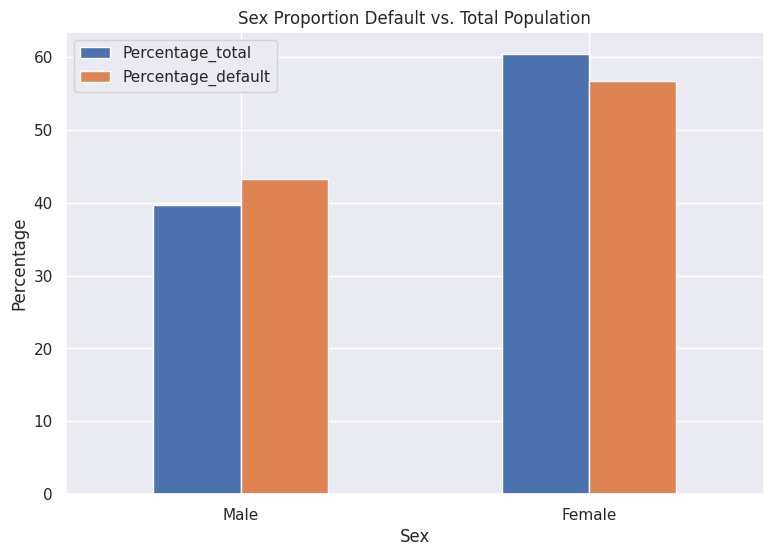

In [ ]:
# Plot the sex proportion (1=male, 2=female) of the total and default population
plot_total_default_percentage(df_plot=tmp_sex.join(df_default.groupBy('SEX').agg(round(F.count('SEX')*100 / df_default.count(),2).alias('Percentage_default')), 'SEX'),
                            x='SEX',
                            title='Sex Proportion Default vs. Total Population',
                            x_label = 'Sex',
                            y_label = 'Percentage',
                            x_ticklabels = ('Male', 'Female'))

In [ ]:
# See the education proportion of total vs default population:
# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
tmp_edu = df.groupBy('EDUCATION').agg((round(F.count('EDUCATION')*100 / df.count(),2)).alias('Percentage_total')).sort('Percentage_total')

tmp_edu.join(df_default.groupBy('EDUCATION').agg(round(F.count('EDUCATION')*100 / df_default.count(),2).alias('Percentage_default')), 'EDUCATION').sort('Percentage_total').show()


+---------+----------------+------------------+
|EDUCATION|Percentage_total|Percentage_default|
+---------+----------------+------------------+
|        4|            1.56|               0.5|
|        3|           16.39|             18.64|
|        1|           35.28|             30.68|
|        2|           46.77|             50.18|
+---------+----------------+------------------+



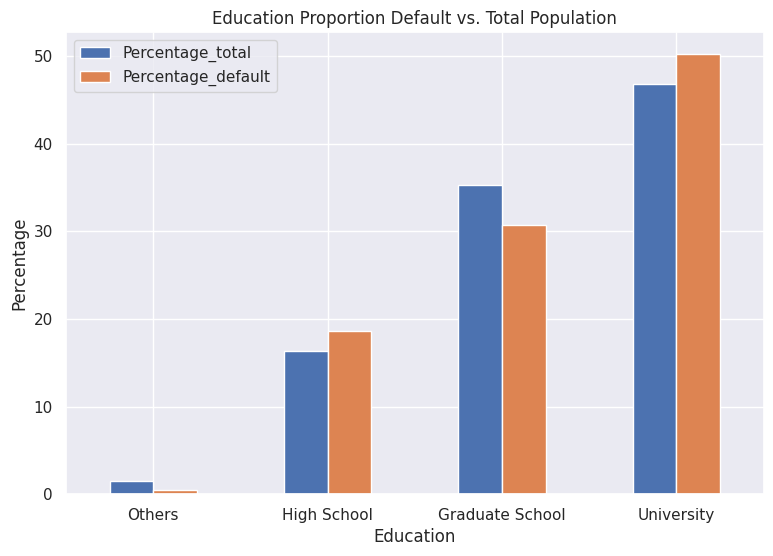

In [ ]:
# Plot the education proportion of total vs default population:
# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
plot_total_default_percentage(df_plot=tmp_edu.join(df_default.groupBy('EDUCATION').agg(round(F.count('EDUCATION')*100 / df_default.count(),2).alias('Percentage_default')), 'EDUCATION').sort('Percentage_total'),
                            x='EDUCATION',
                            title='Education Proportion Default vs. Total Population',
                            x_label = 'Education',
                            y_label = 'Percentage',
                            x_ticklabels = ("Others", "High School", "Graduate School", "University"))

In [ ]:
# See the marriage proportion of total vs default population:
# MARITAL STATUS: (1 = married; 2 = single; 3 = others).
tmp_rel = df.groupBy('MARRIAGE').agg((round(F.count('MARRIAGE')*100 / df.count(),2)).alias('Percentage_total')).sort('Percentage_total')

tmp_rel.join(df_default.groupBy('MARRIAGE').agg(round(F.count('MARRIAGE')*100 / df_default.count(),2).alias('Percentage_default')), 'MARRIAGE').sort('Percentage_total').show()


+--------+----------------+------------------+
|MARRIAGE|Percentage_total|Percentage_default|
+--------+----------------+------------------+
|       3|            1.26|              1.34|
|       1|           45.53|             48.31|
|       2|           53.21|             50.35|
+--------+----------------+------------------+



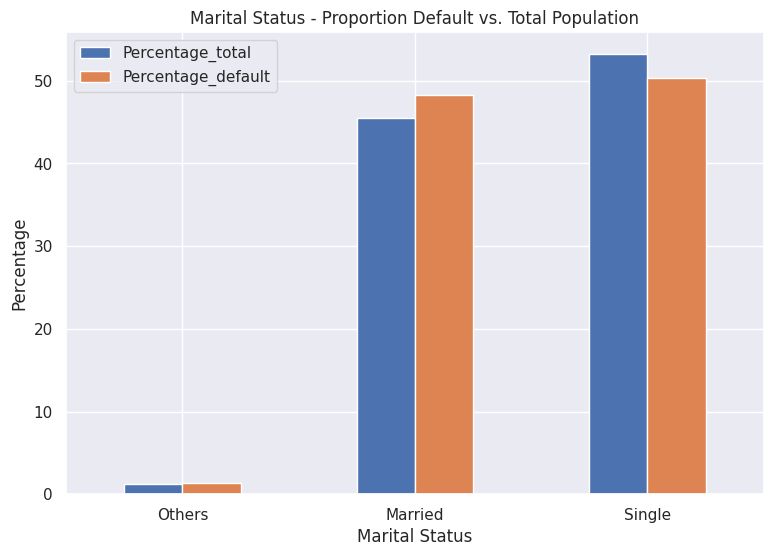

In [ ]:
# Plot the marriage proportion of total vs default population:
# MARITAL STATUS: (1 = married; 2 = single; 3 = others).
plot_total_default_percentage(df_plot=tmp_rel.join(df_default.groupBy('MARRIAGE').agg(round(F.count('MARRIAGE')*100 / df_default.count(),2).alias('Percentage_default')), 'MARRIAGE').sort('Percentage_total'),
                            x='MARRIAGE',
                            title='Marital Status - Proportion Default vs. Total Population',
                            x_label = 'Marital Status',
                            y_label = 'Percentage',
                            x_ticklabels = ("Others", "Married", "Single"))

In [ ]:
# See the age proportion of total vs default population:

tmp_age = df.groupBy('AGE').agg((round(F.count('AGE')*100 / df.count(),2)).alias('Percentage_total')).sort('AGE')
tmp_age.join(df_default.groupBy('AGE').agg(round(F.count('AGE')*100 / df_default.count(),2).alias('Percentage_default')), 'AGE').sort('AGE').show()

+---+----------------+------------------+
|AGE|Percentage_total|Percentage_default|
+---+----------------+------------------+
| 21|            0.22|              0.21|
| 22|            1.87|              2.55|
| 23|             3.1|              3.72|
| 24|            3.76|              4.52|
| 25|            3.95|              4.55|
| 26|            4.19|              3.81|
| 27|            4.92|              4.72|
| 28|             4.7|              4.31|
| 29|            5.35|              4.72|
| 30|            4.65|              4.13|
| 31|            4.06|              3.45|
| 32|            3.86|              3.39|
| 33|            3.82|              3.24|
| 34|            3.87|              3.48|
| 35|            3.71|              3.41|
| 36|            3.69|              3.83|
| 37|            3.47|              3.45|
| 38|            3.15|              2.92|
| 39|            3.18|               3.0|
| 40|             2.9|              2.82|
+---+----------------+------------

Text(0, 0.5, 'Percentage')

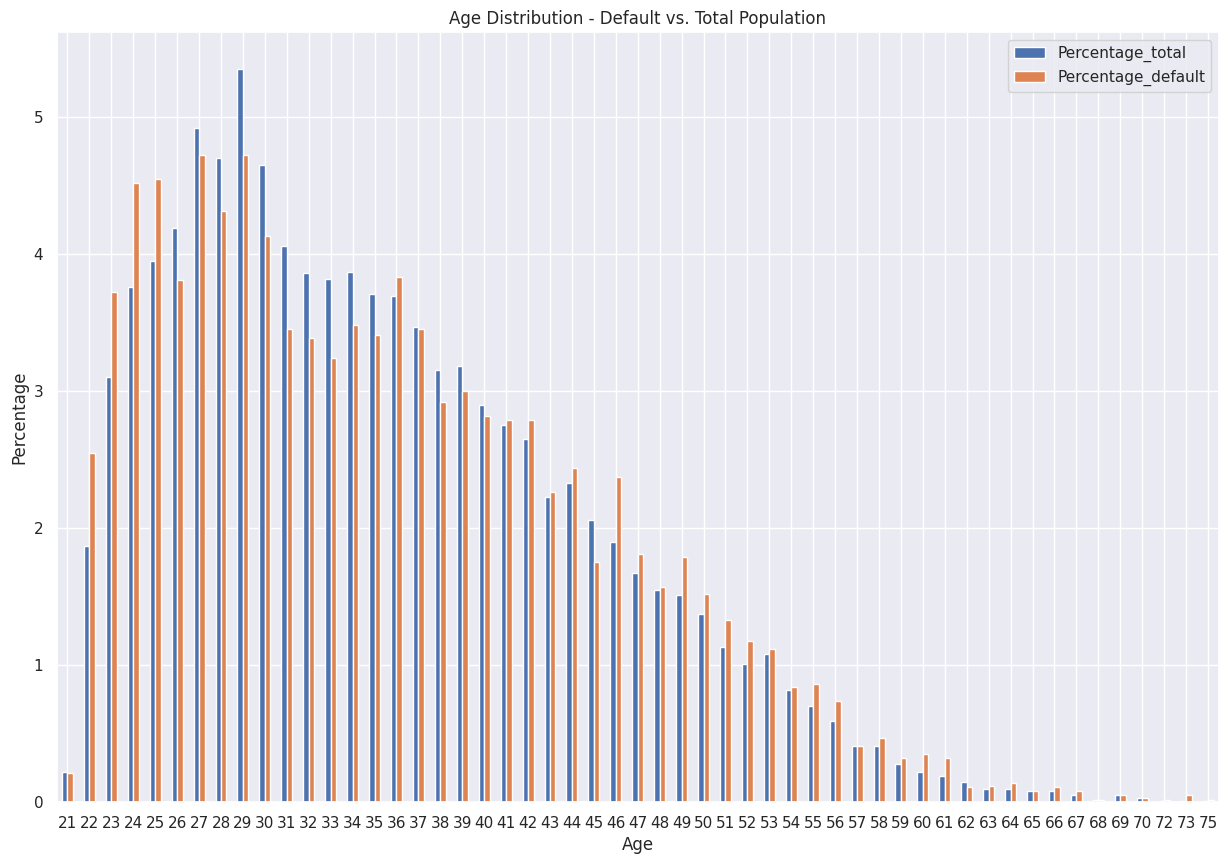

In [ ]:
# Plot the age distribution default vs. total
pdf_age=tmp_age.join(df_default.groupBy('AGE').agg(round(F.count('AGE')*100 / df_default.count(),2).alias('Percentage_default')), 'AGE').sort('AGE').toPandas()
ax=pdf_age.plot.bar(x='AGE', rot=0, figsize=(15, 10))
ax.set_title('Age Distribution - Default vs. Total Population')
ax.set_xlabel('Age')
ax.set_ylabel('Percentage')


In [ ]:
# Mean age in the default population
mean_default_age = df_default.select(mean('AGE')).collect()[0][0]
print(mean_default_age)

35.72573839662447


In [ ]:
# Mean age in the total population
mean_age = df.select(mean('AGE')).collect()[0][0]
print(mean_age)

35.4855


In [ ]:
# See the limit balance of total vs default population:

tmp_limit = df.groupBy('LIMIT_BAL').agg((round(F.count('LIMIT_BAL')*100 / df.count(),2)).alias('Percentage_total')).sort('LIMIT_BAL')
tmp_limit.join(df_default.groupBy('LIMIT_BAL').agg(round(F.count('LIMIT_BAL')*100 / df_default.count(),2).alias('Percentage_default')), 'LIMIT_BAL').sort('LIMIT_BAL').show()

+---------+----------------+------------------+
|LIMIT_BAL|Percentage_total|Percentage_default|
+---------+----------------+------------------+
|    10000|            1.64|              2.97|
|   100000|            3.49|               4.1|
|   110000|            1.96|              1.99|
|   120000|            2.42|               2.7|
|   130000|            2.43|              2.37|
|   140000|             2.5|              2.56|
|   150000|             3.7|              2.82|
|   160000|            2.31|              2.06|
|   170000|            1.77|              1.18|
|   180000|            3.32|              2.65|
|   190000|            0.76|              0.74|
|    20000|            6.59|             10.52|
|   200000|            5.09|              4.07|
|   210000|            2.43|              1.76|
|   220000|            1.56|              1.34|
|   230000|            2.46|               1.7|
|   240000|            2.06|              1.66|
|   250000|            1.17|            

### Exploring payment patterns

In [ ]:
# Explanation of variables:
# X6 - X11: History of past payment witg X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . . X11 = the repayment status in April, 2005
# The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . .
# for an updated (but not sure how reliable) explanation see: https://www.kaggle.com/code/heydido/eda-fe-modeltraining-default-of-credit-cards#%E2%96%B6%EF%B8%8F-Dataset-info-updated-from-various-comments:
df_default = df_default.withColumn("PAY_1", df_default["PAY_1"].cast(IntegerType()))

mean_default_PAY_1 = df_default.select(mean('PAY_1')).collect()[0][0]
print(mean_default_PAY_1)

0.6681735985533453


In [ ]:
feature = 'PAY_1'
df_default.groupBy(feature).agg(round(F.count(feature)*100/ df_default.count(),2).alias(f'{feature}_prop')).sort(feature).show()

+-----+----------+
|PAY_1|PAY_1_prop|
+-----+----------+
|   -2|       5.5|
|   -1|     14.38|
|    0|     28.45|
|    1|     18.87|
|    2|     27.79|
|    3|      3.68|
|    4|      0.78|
|    5|       0.2|
|    6|      0.09|
|    7|      0.11|
|    8|      0.17|
+-----+----------+



In [ ]:
mean_default_PAY_2 = df_default.select(mean('PAY_2')).collect()[0][0]
print(mean_default_PAY_2)

0.4582579867389994


In [ ]:
mean_default_PAY_3 = df_default.select(mean('PAY_3')).collect()[0][0]
print(mean_default_PAY_3)

0.36211573236889694


In [ ]:
mean_default_PAY_4 = df_default.select(mean('PAY_4')).collect()[0][0]
print(mean_default_PAY_4)

0.25452079566003616


In [ ]:
mean_default_PAY_5 = df_default.select(mean('PAY_5')).collect()[0][0]
print(mean_default_PAY_5)

0.16787221217600964


In [ ]:
# We see that PAY_1, PAY_2,..., PAY_6 monotonically decrease which implies higher delay for more recent repayments, for default customers:
mean_default_PAY_6 = df_default.select(mean('PAY_6')).collect()[0][0]
print(mean_default_PAY_6)

0.11211573236889692


In [ ]:
# The same phenomena happens for the total population: PAY_1, PAY_2,..., PAY_6 monotonically decreasing (all negative values, indicating ontime or early payments)
mean_PAY_1 = df.select(mean('PAY_1')).collect()[0][0]
print(mean_PAY_1)

-0.0167


In [ ]:
mean_PAY_2 = df.select(mean('PAY_2')).collect()[0][0]
print(mean_PAY_2)

-0.13376666666666667


In [ ]:
mean_PAY_3 = df.select(mean('PAY_3')).collect()[0][0]
print(mean_PAY_3)

-0.1662


In [ ]:
mean_PAY_4 = df.select(mean('PAY_4')).collect()[0][0]
print(mean_PAY_4)

-0.22066666666666668


In [ ]:
mean_PAY_5 = df.select(mean('PAY_5')).collect()[0][0]
print(mean_PAY_5)

-0.2662


In [ ]:
mean_PAY_6 = df.select(mean('PAY_6')).collect()[0][0]
print(mean_PAY_6)

-0.2911


### SQL

In [ ]:
# Syntax of createOrReplaceTempView()

df.createOrReplaceTempView("df_view")
spark.sql("select * from df_view").show()

+----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|
+----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| 164|   250000|  2|        1|       1| 34|    0|    0|    2|    0|    0|    0|   141223|   156858|   151841|   152803|   155997|   160220|   17994|       0|    5469|    5656|    6811|    3920|      0|
| 235|    60000|  2|        2|       1| 33|    0|    0|    0|    0|    0|    0|    58203|    36367|    20934|    20694|    20175|    19421|    1506|    1298|    1000|     721|     811|     599

In [ ]:
# Let us look at risky customers with high limit balance and who failed to pay the last couple of monthly payments on time:
spark.sql("select * from df_view where LIMIT_BAL>500000 and PAY_6+PAY_5>0").show()

+-----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|   ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|
+-----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|15354|   520000|  2|        1|       1| 46|    1|    2|    2|    0|    0|    2|   133890|   106928|    37238|    36293|    55826|    34989|    5022|       0|   20000|   40000|       0|    5000|      0|
|13047|   660000|  1|        1|       2| 40|    0|    0|    0|    0|    2|    0|   142417|   122122|   104284|   113345|   111423|   119349|    6500|    6000|   15000|       0|   10000|   

In [ ]:
# Let us look at risky customers with total payment amount in the past 6 months exceeding the total bill amounts:
spark.sql("select * from df_view where  (BILL_AMT6+BILL_AMT5+BILL_AMT4+BILL_AMT3+BILL_AMT2+BILL_AMT1- PAY_AMT6 - PAY_AMT5-PAY_AMT4-PAY_AMT3-PAY_AMT2-PAY_AMT1)<0").show()

+-----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|   ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|
+-----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| 1258|   180000|  2|        1|       2| 28|   -1|   -1|   -1|   -1|   -1|    0|      950|     4369|     9673|     2861|    12338|     9124|    4369|    9673|    3260|   13959|    3000|   18396|      0|
| 2820|   240000|  2|        1|       1| 38|    1|   -2|   -2|   -2|   -2|   -2|        0|        0|        0|        0|        0|        0|       0|  100000|       0|       0|       0|   

In [ ]:
# Let us look at risky customers who failed to pay more than half of the last payment due:
spark.sql("select count(ID),default from df_view where  BILL_AMT6 -PAY_AMT6> 0.5*BILL_AMT6 group by default").show()

+---------+-------+
|count(ID)|default|
+---------+-------+
|    15376|      0|
|     4773|      1|
+---------+-------+



In [ ]:
# Let us look at customers who did not fulfill any payment in the past 6 months:
spark.sql("select count(ID), default from df_view where  PAY_AMT1+PAY_AMT2+PAY_AMT3+PAY_AMT4+PAY_AMT5+PAY_AMT6 =0 group by default").show()

+---------+-------+
|count(ID)|default|
+---------+-------+
|      888|      0|
|      544|      1|
+---------+-------+



In [ ]:
# Customers who are on average late for each previous payment are more likely to default, as expected:
spark.sql("select count(ID),default, avg(LIMIT_BAL) from df_view where  PAY_1+PAY_2+PAY_3+PAY_4+PAY_5+PAY_6> 6 group by default").show()

+---------+-------+-----------------+
|count(ID)|default|   avg(LIMIT_BAL)|
+---------+-------+-----------------+
|      941|      0|88012.75239107333|
|     1692|      1| 90862.8841607565|
+---------+-------+-----------------+



In [ ]:
# Customers who are on average early for each previous payment are much less likely to default, as expected and have higher average limit balance:
spark.sql("select count(ID),default, avg(LIMIT_BAL) from df_view where  PAY_1+PAY_2+PAY_3+PAY_4+PAY_5+PAY_6< 0 group by default").show()

+---------+-------+------------------+
|count(ID)|default|    avg(LIMIT_BAL)|
+---------+-------+------------------+
|    10646|      0|211363.89254179972|
|     2029|      1| 188137.0133070478|
+---------+-------+------------------+



In [ ]:
spark.sql("select count(ID),default, avg(LIMIT_BAL),\
avg(PAY_1+PAY_2+PAY_3+PAY_4+PAY_5+PAY_6) as avg_total_payment_delay, \
avg(BILL_AMT1+BILL_AMT2+BILL_AMT3+BILL_AMT4+BILL_AMT5+BILL_AMT6) as avg_total_bill_statement, \
avg(PAY_AMT1+PAY_AMT2+PAY_AMT3+PAY_AMT4+PAY_AMT5+PAY_AMT6) as avg_total_prev_payment from df_view group by default").show()

+---------+-------+------------------+-----------------------+------------------------+----------------------+
|count(ID)|default|    avg(LIMIT_BAL)|avg_total_payment_delay|avg_total_bill_statement|avg_total_prev_payment|
+---------+-------+------------------+-----------------------+------------------------+----------------------+
|    23364|      0|178099.72607430234|     -1.980140386920048|      272428.90784968325|     34969.42064714946|
|     6636|      1|130109.65641952984|     2.0230560578661843|      260822.95554550935|    19969.293701024715|
+---------+-------+------------------+-----------------------+------------------------+----------------------+



## Modeling and hyperparameter tuning
NOTE: the results may differ between runs for some models

### Prepare feature vector

In [ ]:
from pyspark.sql.types import IntegerType, FloatType
features = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "LIMIT_BAL", "EDUCATION", "MARRIAGE", "AGE", "SEX", "default"]
for feature in features:
  df = df.withColumn(feature, df[feature].cast(IntegerType()))

features = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
            "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5", "PAY_AMT6" ]
for feature in features:
  df = df.withColumn(feature, df[feature].cast(FloatType()))




In [ ]:
df.columns[1:24]

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [ ]:
feature = VectorAssembler(inputCols=df.columns[1:24],outputCol="features")
feature_vector= feature.transform(df)

In [ ]:
mean_BILL_AMT6 = df.select(mean('BILL_AMT6')).collect()[0][0]
print(mean_BILL_AMT6)

38871.7604


In [ ]:
feature_vector.show()

+----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+--------------------+
|  ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default|            features|
+----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+--------------------+
| 164|   250000|  2|        1|       1| 34|    0|    0|    2|    0|    0|    0| 141223.0| 156858.0| 151841.0| 152803.0| 155997.0| 160220.0| 17994.0|     0.0|  5469.0|  5656.0|  6811.0|  3920.0|      0|[250000.0,2.0,1.0...|
| 235|    60000|  2|        2|       1| 33|    0|    0|    0|    0|    0|    0|  58203.0|  36367.0|  20934.0

In [ ]:
(trainingData, testData) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

### Prepare evaluators

In [ ]:
# BinaryClassificationEvaluator for caluclating ROC AUC metric
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html
bin_evaluator = BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC")

# MulticlassClassificationEvaluator for calculating accuracy metric
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
multi_evaluator = MulticlassClassificationEvaluator(labelCol="default", predictionCol="prediction", metricName="accuracy")

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="default", featuresCol="features")
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)

# lr_prediction.select("prediction", "default", "features").show()

lr_accuracy = multi_evaluator.evaluate(lr_prediction)
print("Accuracy of LogisticRegression is = %.4f"% (lr_accuracy))

lr_rocauc = bin_evaluator.evaluate(lr_prediction)
print("ROC AUC score of LogisticRegression is = %.4f"% (lr_rocauc))

Accuracy of LogisticRegression is = 0.8162
ROC AUC score of LogisticRegression is = 0.6042


In [ ]:
# https://spark.apache.org/docs/latest/ml-tuning.html

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20, 30]) \
    .addGrid(lr.regParam, [0, 0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

lrcvModel = crossval.fit(trainingData)
lrcv_prediction = lrcvModel.transform(testData)

# lrcv_prediction.select("prediction", "default", "features").show()

lr_accuracy = multi_evaluator.evaluate(lrcv_prediction)
print("Accuracy of LogisticRegression is = %.4f"% (lr_accuracy))

lr_rocauc = bin_evaluator.evaluate(lrcv_prediction)
print("ROC AUC score of LogisticRegression is = %.4f"% (lr_rocauc))

Accuracy of LogisticRegression is = 0.8158
ROC AUC score of LogisticRegression is = 0.6035


In [ ]:
# Access the best model from the cross-validation
best_model = lrcvModel.bestModel

# Retrieve the best parameters from the best model
best_maxIter = best_model.getMaxIter()
best_regParam = best_model.getRegParam()

# Print the best parameters
print("Best maxIter:", best_maxIter)
print("Best regParam:", best_regParam)

Best maxIter: 20
Best regParam: 0.0


In [ ]:
!pip install spark_ml_utils

In [ ]:
import spark_ml_utils.LogisticRegressionModel_util as lu
lr_featureImportanceOverview = lu.feature_importance(lrm_model=lrModel
                      , trainDF=trainingData, trainFeatures='features'
                      , nonzero_only=True)
lr_featureImportanceOverview

,feature_index,feature_name,coef,mean,std,std_coef,feature_importance
0,5,PAY_1,5.692809e-01,-0.010843,1.125135,0.640518,0.640518
1,11,BILL_AMT1,-4.418282e-06,51262.277421,73445.390041,-0.324502,0.324502
2,18,PAY_AMT2,-1.067429e-05,5910.238594,23368.790701,-0.249445,0.249445
3,17,PAY_AMT1,-1.259595e-05,5722.766953,17268.024457,-0.217507,0.217507
4,0,LIMIT_BAL,-8.574135e-07,167021.422971,129731.350489,-0.111233,0.111233
5,13,BILL_AMT3,1.543361e-06,47087.414964,69200.331158,0.106801,0.106801
6,6,PAY_2,8.140968e-02,-0.128826,1.198856,0.097598,0.097598
7,3,MARRIAGE,-1.752246e-01,1.558679,0.521704,-0.091415,0.091415
8,12,BILL_AMT2,1.242336e-06,49309.623029,71095.947868,0.088325,0.088325
9,7,PAY_3,7.260385e-02,-0.160063,1.200327,0.087148,0.087148


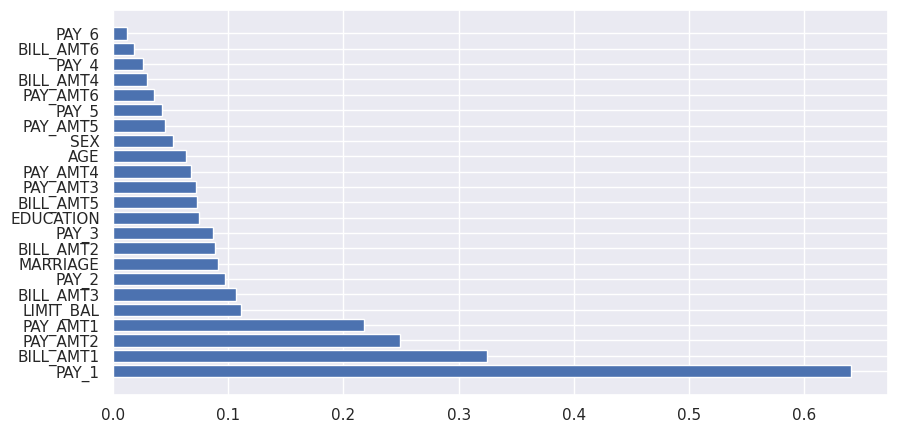

In [ ]:
lr_featureNames = lr_featureImportanceOverview.feature_name
lr_importances = lr_featureImportanceOverview.feature_importance

fig = plt.figure(figsize = (10, 5))
plt.barh(lr_featureNames, lr_importances)
plt.show()


In [ ]:
#investigate which n features to use
n = sum(1 for i in lr_importances if i > 0.02)
n

21

In [ ]:
best_n_features= lr_importances.argsort()[-n:][::-1]
best_n_features= best_n_features.tolist()

vs= VectorSlicer(inputCol='features',  outputCol='best_features',indices=best_n_features)
bestFeatures_lr= vs.transform(feature_vector)
(trainingDataBest, testDataBest) = bestFeatures_lr.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
lr_2 = LogisticRegression(labelCol="default", featuresCol="best_features")
lr_model_2 = lr_2.fit(trainingDataBest)
lr_prediction_2 = lr_model_2.transform(testDataBest)

paramGrid = ParamGridBuilder() \
    .addGrid(lr_2.maxIter, [10, 20, 30]) \
    .addGrid(lr_2.regParam, [0, 0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=lr_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

lrcvModel_2 = crossval.fit(trainingDataBest)
lrcvModel_2_prediction = lrcvModel_2.transform(testDataBest)

# lrcvModel_2_prediction.select("prediction", "default", "features").show()

lr_accuracy = multi_evaluator.evaluate(lrcvModel_2_prediction)
print("Accuracy of LogisticRegression with Most Important Features is = %.4f"% (lr_accuracy))
lr_rocauc = bin_evaluator.evaluate(lrcvModel_2_prediction)
print("ROC AUC score of LogisticRegression with Most Important Features is = %.4f"% (lr_rocauc))

Accuracy of LogisticRegression with Most Important Features is = 0.8153


### Gradient-boosted trees

In [ ]:
# Gradient-boosted trees:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="default", featuresCol="features",maxIter=5, maxDepth=3)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)

# gbt_prediction.select("prediction", "default", "features").show()

gbt_accuracy = multi_evaluator.evaluate(gbt_prediction)
print("Accuracy of Gradient-boosted tree classifier is = %.4f"% (gbt_accuracy))

gbt_rocauc = bin_evaluator.evaluate(gbt_prediction)
print("ROC AUC score of Gradient-boosted tree classifier is = %.4f"% (gbt_rocauc))

Accuracy of Gradient-boosted tree classifier is = 0.8258
ROC AUC score of Gradient-boosted tree classifier is = 0.6553


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [20, 30, 40, 50]) \
    .addGrid(gbt.maxDepth, [2, 3, 4, 5]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

gbtcvModel = crossval.fit(trainingData)
gbtcv_prediction = gbtcvModel.transform(testData)

# gbtcv_prediction.select("prediction", "default", "features").show()

gbt_accuracy = multi_evaluator.evaluate(gbtcv_prediction)
print("Accuracy of Gradient-Boosted Tree Classifier  is = %.4f"% (gbt_accuracy))

gbt_rocauc = bin_evaluator.evaluate(gbtcv_prediction)
print("ROC AUC score of Gradient-Boosted Tree Classifier  is = %.4f"% (gbt_rocauc))


Accuracy of Gradient-Boosted Tree Classifier  is = 0.8266
ROC AUC score of Gradient-Boosted Tree Classifier  is = 0.6570


In [ ]:
# Access the best model from the cross-validation
best_model = gbtcvModel.bestModel

# Retrieve the best parameters from the best model
best_maxIter = best_model.getMaxIter()
best_maxDepth = best_model.getMaxDepth()

# Print the best parameters
print("Best maxIter:", best_maxIter)
print("Best maxDepth:", best_maxDepth)

Best maxIter: 20
Best maxDepth: 3


In [ ]:
# feature importances
gbt_importances = gbt_model.featureImportances
feature_list = df.columns[1:24]

print("Feature Importances:")
for feature, gbt_importance in zip(feature_list, gbt_importances):
    print(f"{feature}: {gbt_importance:.4f}")

Feature Importances:
LIMIT_BAL: 0.0973
SEX: 0.0000
EDUCATION: 0.0104
MARRIAGE: 0.0000
AGE: 0.0000
PAY_1: 0.4109
PAY_2: 0.1120
PAY_3: 0.1156
PAY_4: 0.0000
PAY_5: 0.0424
PAY_6: 0.0054
BILL_AMT1: 0.0637
BILL_AMT2: 0.0000
BILL_AMT3: 0.0000
BILL_AMT4: 0.0000
BILL_AMT5: 0.0000
BILL_AMT6: 0.0067
PAY_AMT1: 0.0652
PAY_AMT2: 0.0085
PAY_AMT3: 0.0237
PAY_AMT4: 0.0270
PAY_AMT5: 0.0109
PAY_AMT6: 0.0000


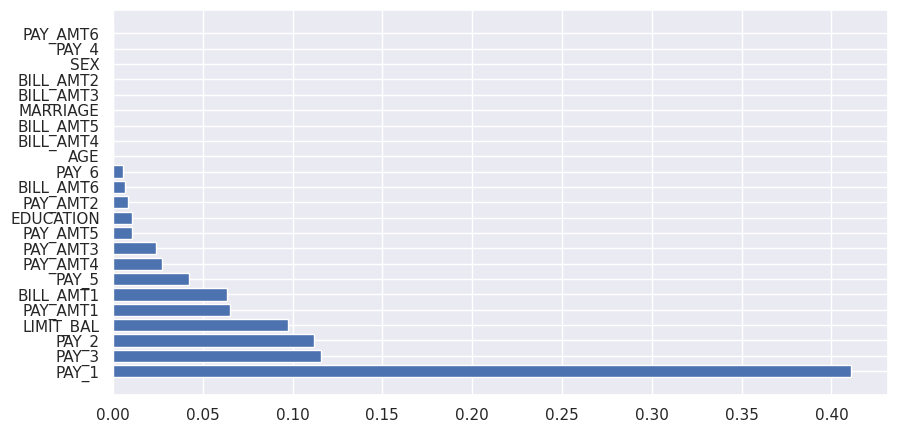

In [ ]:
# plot the feature importances

gbt_importances = gbt_importances.toArray()
gbt_imps = pd.DataFrame(dict(feature_list=feature_list, gbt_importances=gbt_importances))
gbt_imps_sorted = gbt_imps.sort_values('gbt_importances', ascending=False)
fig = plt.figure(figsize = (10, 5))
plt.barh('feature_list', 'gbt_importances', data=gbt_imps_sorted)
plt.show()


In [ ]:
#determine which n features to use
n = sum(1 for i in gbt_importances if i > 0.02)
n

9

In [ ]:
best_n_features= gbt_importances.argsort()[-n:][::-1]
best_n_features= best_n_features.tolist()

vs= VectorSlicer(inputCol='features',  outputCol='best_features',indices=best_n_features)
bestFeatures_gbt= vs.transform(feature_vector)
(trainingDataBest, testDataBest) = bestFeatures_gbt.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
gbt_2 = GBTClassifier(labelCol="default", featuresCol="best_features", maxIter=5, maxDepth=3)
gbt_model_2 = gbt_2.fit(trainingDataBest)
gbt_prediction_2 = gbt_model_2.transform(testDataBest)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt_2.maxIter, [20, 30, 40, 50]) \
    .addGrid(gbt_2.maxDepth, [2, 3, 4, 5]) \
    .build()

crossval = CrossValidator(estimator=gbt_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

gbtModel_2 = crossval.fit(trainingDataBest)
gbtModel_2_prediction = gbtModel_2.transform(testDataBest)

# gbtModel_2_prediction.select("prediction", "default", "features").show()

gbt_accuracy = multi_evaluator.evaluate(gbtModel_2_prediction)
print("Accuracy of Gradient-Boosted Tree Classifierr with Most Important Features is = %.4f"% (gbt_accuracy))
gbt_rocauc = bin_evaluator.evaluate(gbtModel_2_prediction)
print("ROC AUC score of Gradient-Boosted Tree Classifier with Most Important Features is = %.4f"% (gbt_rocauc))

Accuracy of Gradient-Boosted Tree Classifierr with Most Important Features is = 0.8260


### Decision Tree

In [ ]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="default", featuresCol="features", maxDepth=7, seed=1)
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)
# dt_prediction.select("prediction", "default", "features").show()

dt_accuracy = multi_evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTree is = %.4f"% (dt_accuracy))

dt_rocauc = bin_evaluator.evaluate(dt_prediction)
print("ROC AUC score of DecisionTree is = %.4f"% (dt_rocauc))

Accuracy of DecisionTree is = 0.8268
ROC AUC score of DecisionTree is = 0.6582


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3, 4, 5, 6, 7]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)


dtcvModel = crossval.fit(trainingData)
dtcv_prediction = dtcvModel.transform(testData)

# prediction.select("prediction", "default", "features").show()

dt_accuracy = multi_evaluator.evaluate(dtcv_prediction)
print("Accuracy of DecisionTree is = %.4f"% (dt_accuracy))

dt_rocauc = bin_evaluator.evaluate(dtcv_prediction)
print("ROC AUC score of DecisionTree is = %.4f"% (dt_rocauc))

Accuracy of DecisionTree is = 0.8275
ROC AUC score of DecisionTree is = 0.6471


In [ ]:
# Access the best model from the cross-validation
best_model = dtcvModel.bestModel

# Retrieve the best parameters from the best model
best_maxDepth = best_model.getMaxDepth()

# Print the best parameters
print("Best maxDepth:", best_maxDepth)

Best maxDepth: 4


#### Feature Importances

In [ ]:
# feature importances
dt_importances = dt_model.featureImportances
feature_list = df.columns[1:24]

print("Feature Importances:")
for feature, dt_importance in zip(feature_list, dt_importances):
    print(f"{feature}: {dt_importance:.4f}")

Feature Importances:
LIMIT_BAL: 0.0158
SEX: 0.0012
EDUCATION: 0.0045
MARRIAGE: 0.0025
AGE: 0.0117
PAY_1: 0.6531
PAY_2: 0.1283
PAY_3: 0.0172
PAY_4: 0.0038
PAY_5: 0.0304
PAY_6: 0.0098
BILL_AMT1: 0.0248
BILL_AMT2: 0.0048
BILL_AMT3: 0.0042
BILL_AMT4: 0.0026
BILL_AMT5: 0.0005
BILL_AMT6: 0.0043
PAY_AMT1: 0.0067
PAY_AMT2: 0.0056
PAY_AMT3: 0.0462
PAY_AMT4: 0.0062
PAY_AMT5: 0.0068
PAY_AMT6: 0.0091


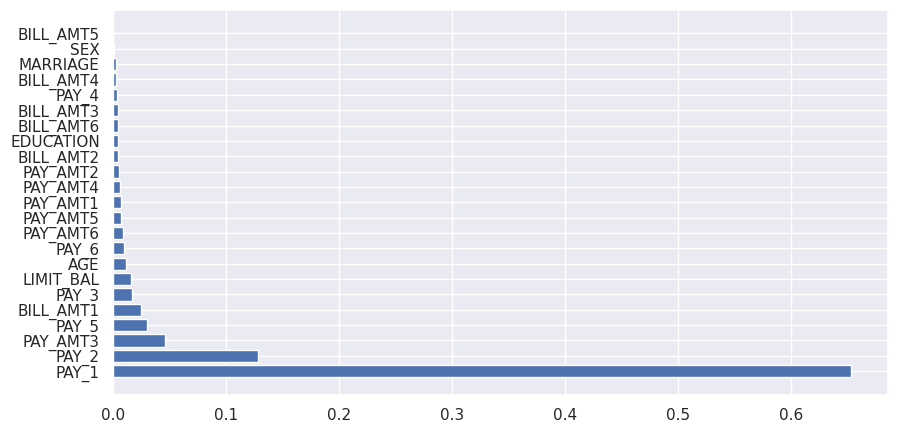

In [ ]:
# plot feature importances
dt_importances = dt_model.featureImportances.toArray()
dt_imps = pd.DataFrame(dict(feature_list=feature_list, dt_importances=dt_importances))
dt_imps_sorted = dt_imps.sort_values('dt_importances', ascending=False)
fig = plt.figure(figsize = (10, 5))
plt.barh('feature_list', 'dt_importances', data=dt_imps_sorted)
plt.show()

In [ ]:
#determine which n features to use
n = sum(1 for i in dt_importances if i > 0.02)
n

5

In [ ]:
from pyspark.ml.feature import VectorSlicer
best_n_features= dt_importances.argsort()[-n:][::-1]
best_n_features= best_n_features.tolist()

vs= VectorSlicer(inputCol='features',  outputCol='best_features',indices=best_n_features)
bestFeatures_dt= vs.transform(feature_vector)
(trainingDataBest, testDataBest) = bestFeatures_dt.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
dt_2 = DecisionTreeClassifier(labelCol="default", featuresCol="best_features", maxDepth=7, seed=1)
dt_model_2 = dt_2.fit(trainingDataBest)
dt_prediction_2 = dt_model_2.transform(testDataBest)

paramGrid = ParamGridBuilder() \
    .addGrid(dt_2.maxDepth, [2, 3, 4, 5, 6, 7]) \
    .build()

crossval = CrossValidator(estimator=dt_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

dtcvModel_2 = crossval.fit(trainingDataBest)
dtcvModel_2_prediction = dtcvModel_2.transform(testDataBest)

# dtcvModel_2_prediction.select("prediction", "default", "features").show()

dtcvModel_2_accuracy = multi_evaluator.evaluate(dtcvModel_2_prediction)
print("Accuracy of DecisionTree with Most Important Features is = %.4f"% (dtcvModel_2_accuracy))

dtcvModel_2_rocauc = bin_evaluator.evaluate(dtcvModel_2_prediction)
print("ROC AUC score of DecisionTree with Most Important Feature is = %.4f"% (dtcvModel_2_rocauc))


Accuracy of DecisionTree  is = 0.8273
ROC AUC score of DecisionTree is = 0.6594


### Random Forest

In [ ]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="default", featuresCol="features", maxDepth=7, numTrees=10, seed=2)
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)

# rf_prediction.select("prediction", "default", "features").show()

rf_accuracy = multi_evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForest  is = %.4f"% (rf_accuracy))

rf_rocauc = bin_evaluator.evaluate(rf_prediction)
print("ROC AUC score of RandomForest is = %.4f"% (rf_rocauc))

Accuracy of RandomForest  is = 0.8260
ROC AUC score of RandomForest is = 0.6540


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 7, 9, 11]) \
    .addGrid(rf.numTrees, [20, 25, 30, 35]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

rfcvModel = crossval.fit(trainingData)
rfcv_prediction = rfcvModel.transform(testData)

# rfcv_prediction.select("prediction", "default", "features").show()

rfcv_accuracy = multi_evaluator.evaluate(rfcv_prediction)
print("Accuracy of Random Forest Classifier  is = %.4f"% (rfcv_accuracy))

rfcv_rocauc = bin_evaluator.evaluate(rfcv_prediction)
print("ROC AUC score of Random Forest Classifier  is = %.4f"% (rfcv_rocauc))

Accuracy of Random Forest Classifier  is = 0.8265
ROC AUC score of Random Forest Classifier  is = 0.6546


In [ ]:
# Access the best model from the cross-validation
best_model_rf = rfcvModel.bestModel

# Retrieve the parameters of the best model
best_model_params_rf = best_model.extractParamMap()

# Print the best parameters
print("Best maxDepth:", best_model_rf.getMaxDepth())
print("Best numTrees:", best_model_rf.getNumTrees)

# # Print all the parameters
#for key, value in best_model_params.items():
#    print(key, value)

Best maxDepth: 7
Best numTrees: 35


#### Feature Importance

In [ ]:
# feature importances
rf_importances = best_model_rf.featureImportances
feature_list = df.columns[1:24]

print("Feature Importances:")
for feature, rf_importance in zip(feature_list, rf_importances):
    print(f"{feature}: {rf_importance:.4f}")

Feature Importances:
LIMIT_BAL: 0.0232
SEX: 0.0011
EDUCATION: 0.0044
MARRIAGE: 0.0015
AGE: 0.0104
PAY_1: 0.4017
PAY_2: 0.1646
PAY_3: 0.0515
PAY_4: 0.0569
PAY_5: 0.0849
PAY_6: 0.0425
BILL_AMT1: 0.0163
BILL_AMT2: 0.0114
BILL_AMT3: 0.0082
BILL_AMT4: 0.0080
BILL_AMT5: 0.0071
BILL_AMT6: 0.0070
PAY_AMT1: 0.0253
PAY_AMT2: 0.0164
PAY_AMT3: 0.0210
PAY_AMT4: 0.0126
PAY_AMT5: 0.0102
PAY_AMT6: 0.0139


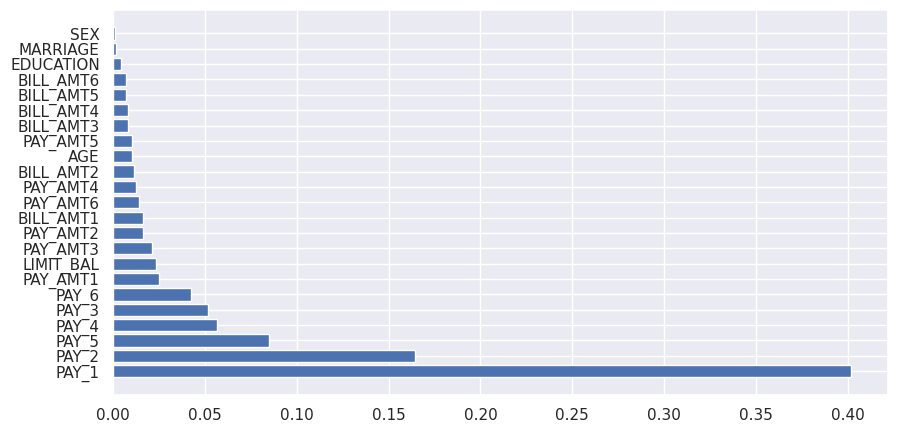

In [ ]:
# plot feature importances
rf_importances = rf_importances.toArray()
rf_imps = pd.DataFrame(dict(feature_list=feature_list, rf_importances=rf_importances))
rf_imps_sorted = rf_imps.sort_values('rf_importances', ascending=False)
fig = plt.figure(figsize = (10, 5))
plt.barh('feature_list', 'rf_importances', data=rf_imps_sorted)
plt.show()

In [ ]:
#find which n features to use
n = sum(1 for i in rf_importances if i > 0.02)
n

9

In [ ]:
best_n_features= rf_importances.argsort()[-n:][::-1]
best_n_features= best_n_features.tolist()

vs= VectorSlicer(inputCol='features',  outputCol='best_features',indices=best_n_features)
bestFeatures_rf= vs.transform(feature_vector)
(trainingData_best, testData_best) = bestFeatures_rf.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
# run everything again but with n best features

rf_2 = RandomForestClassifier(labelCol="default", featuresCol="best_features", maxDepth=7, numTrees=10, seed=2)
rf_model_2 = rf_2.fit(trainingData_best)
rf_prediction_2 = rf_model_2.transform(testData_best)

paramGrid = ParamGridBuilder() \
    .addGrid(rf_2.maxDepth, [3, 5, 7, 9, 11]) \
    .addGrid(rf_2.numTrees, [20, 25, 30, 35]) \
    .build()

crossval = CrossValidator(estimator=rf_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)


rfcvModel_2 = crossval.fit(trainingData_best)
rfcvModel_2_prediction = rfcvModel_2.transform(testData_best)

# rfcvModel_2_prediction.select("prediction", "default", "features").show()

rfcvModel_2_accuracy = multi_evaluator.evaluate(rfcvModel_2_prediction)
print("Accuracy of Random Forest Classifier with Most Important Features is = %.4f"% (rfcvModel_2_accuracy))

rfcvModel_2_rocauc = bin_evaluator.evaluate(rfcvModel_2_prediction)
print("ROC AUC score of Random Forest Classifier with Most Important Feature is = %.4f"% (rfcvModel_2_rocauc))

Accuracy of Random Forest Classifier  is = 0.8270
ROC AUC score of Random Forest Classifier  is = 0.6569


### Linear Support Vector Machine

In [ ]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LinearSVC.html
from pyspark.ml.classification import LinearSVC
svc = LinearSVC(labelCol="default", featuresCol="features",maxIter=5)
svc_model = svc.fit(trainingData)
svc_prediction = svc_model.transform(testData)

# svc_prediction.select("prediction", "default", "features").show()

svc_accuracy = multi_evaluator.evaluate(svc_prediction)
print("Accuracy of LinearSVC  is = %.4f"% (svc_accuracy))

svc_rocauc = bin_evaluator.evaluate(svc_prediction)
print("ROC AUC score of LinearSVC is = %.4f"% (svc_rocauc))

Accuracy of LinearSVC  is = 0.8060
ROC AUC score of LinearSVC is = 0.5658


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(svc.maxIter, [70, 80, 90]) \
    .addGrid(svc.regParam, [0, 0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=svc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

svccvModel = crossval.fit(trainingData)
svccv_prediction = svccvModel.transform(testData)

# svccv_prediction.select("prediction", "default", "features").show()

svccv_accuracy = multi_evaluator.evaluate(svccv_prediction)
print("Accuracy of LinearSVC  is = %.4f"% (svccv_accuracy))

svccv_rocauc = bin_evaluator.evaluate(svccv_prediction)
print("ROC AUC score of LinearSVC is = %.4f"% (svccv_rocauc))

Accuracy of LinearSVC  is = 0.8143
ROC AUC score of LinearSVC is = 0.6003


In [ ]:
# Access the best model from the cross-validation
best_model = svccvModel.bestModel

# Retrieve the best parameters from the best model
best_maxIter = best_model.getMaxIter()
best_regParam = best_model.getRegParam()

# Print the best parameters
print("Best maxIter:", best_maxIter)
print("Best regParam:", best_regParam)

Best maxIter: 80
Best regParam: 0.0


In [ ]:
# SVC does not have feature importances but has feature coefficients
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LinearSVC.html
# https://forecastegy.com/posts/feature-importance-in-logistic-regression/#:~:text=The%20simplest%20way%20to%20calculate,predictor%20and%20the%20target%20variable.
svc_coefficients = svc_model.coefficients
svc_importances=np.abs(svc_coefficients)

svc_imps = pd.DataFrame(dict(feature_list=feature_list, svc_importances=svc_importances))

print("Feature Importances:")
svc_imps

Feature Importances:


,feature_list,svc_importances
0,LIMIT_BAL,8.652292e-08
1,SEX,9.451103e-03
2,EDUCATION,4.776753e-02
3,MARRIAGE,4.501409e-02
4,AGE,9.852115e-04
5,PAY_1,2.688458e-01
6,PAY_2,1.512599e-01
7,PAY_3,5.000060e-02
8,PAY_4,3.900328e-02
9,PAY_5,3.894476e-02


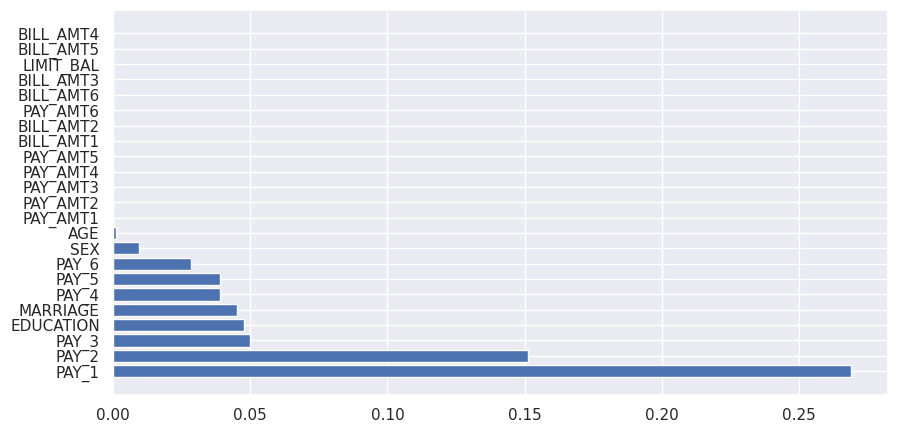

In [ ]:
# plot feature importances
svc_imps_sorted = svc_imps.sort_values('svc_importances', ascending=False)
fig = plt.figure(figsize = (10, 5))
plt.barh('feature_list', 'svc_importances', data=svc_imps_sorted)
plt.show()

In [ ]:
#determine which n features to use
n = sum(1 for i in svc_importances if i > 0.02)
n

8

In [ ]:
from pyspark.ml.feature import VectorSlicer
best_n_features= svc_importances.argsort()[-n:][::-1]
best_n_features= best_n_features.tolist()

vs= VectorSlicer(inputCol='features',  outputCol='best_features',indices=best_n_features)
bestFeatures_svc= vs.transform(feature_vector)
(trainingDataBest, testDataBest) = bestFeatures_svc.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
svc_2 = LinearSVC(labelCol="default", featuresCol="best_features", maxIter=5)
svc_model_2 = svc_2.fit(trainingDataBest)
svc_prediction_2 = svc_model_2.transform(testDataBest)

paramGrid = ParamGridBuilder() \
    .addGrid(svc_2.maxIter, [70, 80, 90]) \
    .addGrid(svc_2.regParam, [0, 0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=svc_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="default", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=3)

svccvModel_2 = crossval.fit(trainingDataBest)
svccvModel_2_prediction = svccvModel_2.transform(testDataBest)

# svccvModel_2_prediction.select("prediction", "default", "features").show()

svccvModel_2_accuracy = multi_evaluator.evaluate(svccvModel_2_prediction)
print("Accuracy of LinearSVC  with Most Important Features is = %.4f"% (svccvModel_2_accuracy))

svccvModel_2_rocauc = bin_evaluator.evaluate(svccvModel_2_prediction)
print("ROC AUC score of LinearSVC with Most Important Feature is = %.4f"% (svccvModel_2_rocauc))


Accuracy of LinearSVC  is = 0.8143
ROC AUC score of LinearSVC is = 0.6003


## Conclusions
- The best-performing models in terms of ROC AUC were Decision Tree and Gradient-Boosted Trees.
- Both of these are tree-based models, which had a quite low maxDepth hyperparameter setting of 3 and 4 respectively for their best settings. This low maxDepth indicates that not so many features were needed for the models to optimize their predictions.
- Examining the feature importance analysis from it can be seen that PAY 1 (repayment status in the last month tracked) is always the most important feature, followed by other payment and billing data for the last two or three months. This means that the most important data for predicting if a customer will default is obtained from the customer’s most recent history.
- When retraining the models with the most important features (using the threshold: feature importance score > 0.02), a similarly high model performance as when training with all the features was achieved. This result, like the low maxDepth setting, also indicates that only a subset of the features is sufficient to reach a similar predictive performance.
- The classification accuracies are all within the range 81-83%. This cap on accuracy could be due to the imbalanced nature of the dataset itself (only about 22% are default records).
- The Decision Tree model demonstrates as good performance as the more complex tree- based models Random Forest and Gradient-Boosted Trees for our tested settings.


